# Compute Photosynthetic Parameters

In [1]:
from plantcv import plantcv as pcv
import numpy as np
import os
import warnings
import importlib
warnings.filterwarnings("ignore", module="matplotlib")
warnings.filterwarnings("ignore", module='plotnine')


In [2]:
pcv.params.debug=None

It can be useful to pull up the help pages for a module you'll be using alot like PlantCV. https://plantcv.readthedocs.io

# Read Images

Image id # from experiment:

- Fo_id = '0000'
- Fm_id = '0007'
- FsLss_id = '0084'
- FmpLss_id = '0085'


In [3]:
Fo,_,_ = pcv.readimage('data/020320 images/GroupA/2-3-2020_Time_1811_Pos_169x1796_0000.jpg')
Fm,_,_ = pcv.readimage('data/020320 images/GroupA/2-3-2020_Time_1811_Pos_169x1796_0007.jpg')
FsLss,_,_ = pcv.readimage('data/020320 images/GroupA/2-3-2020_Time_1811_Pos_169x1796_0084.jpg')
FmpLss,_,_ = pcv.readimage('data/020320 images/GroupA/2-3-2020_Time_1811_Pos_169x1796_0085.jpg')

In [4]:
Fm.shape

(768, 1024, 3)

These appear to be images with 3 channels, often called RGB. However in plantcv the color channels are ordered BGR (blue, green, red)

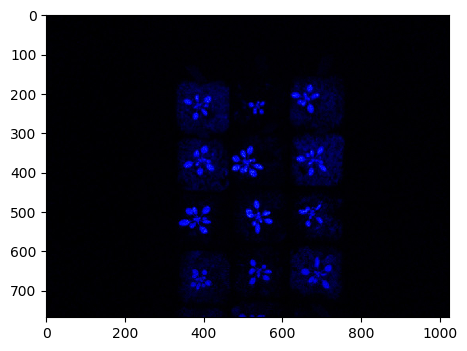

In [5]:
pcv.plot_image(Fm)

This figure the fluorescence is blue so we will need to extract the B channel as a single gray-scale image

In [6]:
Fm = Fm[:,:,0] #remmber that python is 0-based indexing so 0 is the first layer.
Fo = Fo[:,:,0]
FsLss = FsLss[:,:,0]
FmpLss = FmpLss[:,:,0]

# Remove the background

We need to determine what intensity corresponds to plant and what corresponds to background. In this case the plant is mostly brighter than the rest of the image. This means the values of those pixels is greater.

In [7]:
pcv.params.debug=None

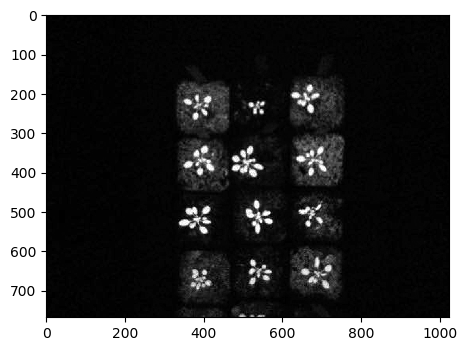

In [8]:
pcv.plot_image(Fm)

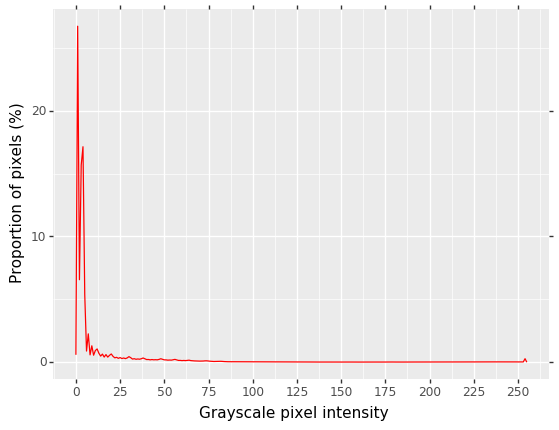

<ggplot: (8727107792561)>


In [9]:
hmax = pcv.visualize.histogram(Fm)
pcv.plot_image(hmax)

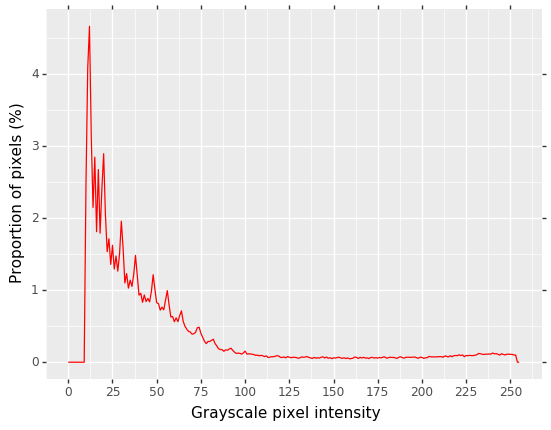

<ggplot: (8727107858089)>


In [10]:
# Lets limit the histogram to 100. We can also remove the lowest values for clarity.
hmax = pcv.visualize.histogram(Fm[np.where(np.logical_and(Fm<255, Fm>10))])
pcv.plot_image(hmax)

In [11]:
#Creates a binary image from a gray image based on the threshold values. The object target can be specified as dark or light.

# plantcv.threshold.binary(gray_img, threshold, max_value, object_type="light")

# returns thresholded/binary image

#     Parameters:
#         gray_img - Grayscale image data
#         threshold - Threshold value (0-255)
#         max_value - Value to apply above threshold (255 = white)
#         object_type - "light" or "dark" (default: "light"). If object is lighter than the background then standard thresholding is done. If object is darker than the background then inverse thresholding is done.


mask = pcv.threshold.binary(Fm, 95 , 255, 'light')

Now we have some left over noise we don't want to include as plant. There are numerous ways of dealing with these spots. For example pcv.fill(), pcv.erode(), pcv.dilate(), pcv.fill_holes()

In [12]:
# Identifies objects and fills objects that are less than specified size

# plantcv.fill(bin_img, size)

# returns fill_image

#     Parameters:
#         bin_img - Binary image data
#         size - minimum object area size in pixels (integer), smaller objects will be filled
#     Context:
#         Used to reduce image noise

# be careful not to fill away small leaves!
fill = pcv.fill(mask, 100)

If you plot the mask, you'll realize there are 12 plants instead of 9 plants. There were 2 groups next to each other so we should remove the bottom/top row of plants to isolate just the group we are interested in.

In [13]:
# Takes an input image and returns a binary image masked by a rectangular area denoted by p1 and p2. Note that p1 = (0,0) is the top left hand corner bottom right hand corner is p2 = (max-value(x), max-value(y)).

# plantcv.rectangle_mask(img, p1, p2, color="black")

# returns masked, binary img, contours, hierarchy

#     Parameters:
#         img - RGB or grayscale image data
#         p1 - Point at the top left corner of rectangle, (0,0) is top left corner (tuple)
#         p2 - Point at the bottom right corner of rectangle (max-value(x),max-value(y)) is bottom right corner (tuple)
#         color - "black", "gray","white", default is "black". This acts to select (mask) area from object capture (need to invert to remove).
#     Context:
#         Used to mask rectangular regions of an image

_,rect,_,_ = pcv.rectangle_mask(img=mask,p1=(300,180),p2=(750,600),color='white')

In [14]:
finalmask = pcv.logical_and(fill, rect) #use logical "and" to combine the masks. must be white in both images to keep in mask

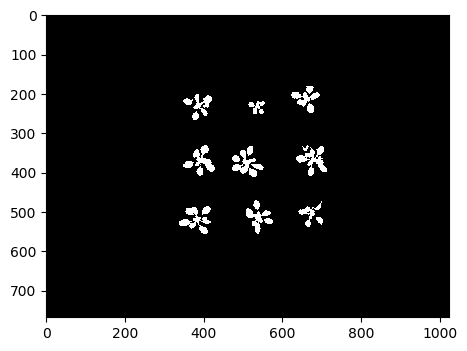

In [15]:
pcv.plot_image(finalmask)

# Apply Mask and Compute FvFm

In [16]:
# SInce fvfm is a decimal from 0-1 we need to create a floating point array of 0s. remember Fm is 'uint8' whihc means unsigned 8 bit integer. The only valid values are 0-255
out_flt = np.zeros_like(Fm, dtype='float')

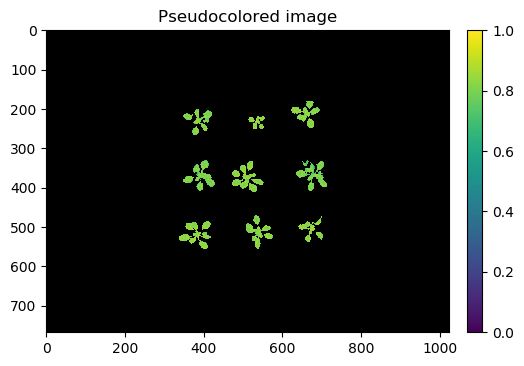

In [17]:
# fv/fm = (Fm-Fo)/Fm
# we can divide arrays by element using np.divide. 
# np.divide(numerator, denominator, out = background values, where = conditions where the calc should occur.)
Fv = np.subtract(Fm,Fo, out=out_flt.copy(), where=finalmask>0)
FvFm = np.divide(Fv,Fm, out=out_flt.copy(), where=np.logical_and(finalmask>0, Fo>0))
fvfm_fig = pcv.visualize.pseudocolor(FvFm,
                        mask=finalmask,
                        cmap='viridis',
                        min_value=0,
                        max_value=1)
fvfm_fig.set_size_inches(6, 6, forward=False)
fvfm_fig.savefig('output/example/example_fvfm.png',
                bbox_inches='tight',
                dpi=150)
fvfm_fig.clf()

Fv/Fm doesn't vary that much in these mutants. You'll need to compute NPQ to determine which plant is which genotype.

# Compute and Visualize NPQ

In [18]:
# npq = Fm/Fm'Lss - 1   
# we can divide arrays by element using np.divide. 
# np.divide(numerator, denominator, out = background values, where = conditions where the calc should occur.)
npq = np.divide(Fm,FmpLss, out=out_flt.copy(), where=np.logical_and(finalmask>0,FmpLss>0))-1


In order to determine which plant has which genotype we'll want to color it based on npq.

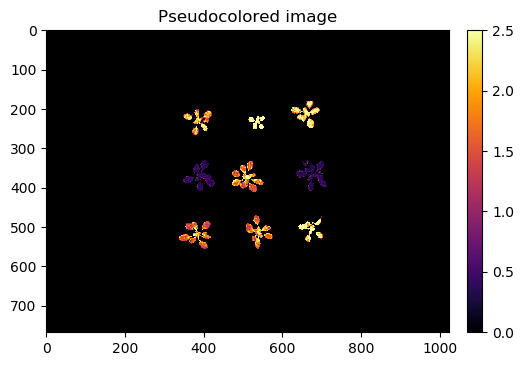

In [19]:
# This function pseudocolors any grayscale image to custom colormap. An optional mask can leave background out in the pseudocolored image. Additionally, optional maximum and minimum values can be specified. When pcv.params.debug='print' then the image gets saved to pcv.params.debug_outdir, andpcv.params.dpi can be set for the image that gets saved. If unaltered, the matplotlib default is 100 pixels per inch.

# plantcv.visualize.pseudocolor(gray_img, obj=None, mask=None, background="image", cmap=None, min_value=0, max_value=255, axes=True, colorbar=True, obj_padding='auto')

# returns pseudocolored image (that can be saved with pcv.print_image)

#     Parameters:
#         gray_img - Grayscale image data
#         obj - ROI or plant contour object (optional) if provided, the pseudocolored image gets cropped down to the region of interest.
#         mask - Binary mask made from selected contours
#         background - Background color/type. Options are "image" (gray_img), "white", or "black". A mask must be supplied.
#         cmap - Custom colormap, see here for tips on how to choose a colormap in Matplotlib.
#         min_value - Minimum value (optional) for range of the colorbar.
#         max_value - Maximum value (optional) for range of the colorbar.
#         axes - If False then the title, x-axis, and y-axis won't be displayed (default axes=True).
#         colorbar - If False then the colorbar won't be displayed (default colorbar=True)
#         obj_padding - if "auto" (default) and an obj is supplied, then the image is cropped to an extent 20% larger in each dimension than the object. A single integer is also accepted to define the padding in pixels.

#     Context:
#         Used to pseudocolor any grayscale image to custom colormap


npq_fig = pcv.visualize.pseudocolor(npq,
                        mask=finalmask,
                        cmap='inferno',
                        min_value = 0,
                        max_value = 2.5)
npq_fig.set_size_inches(6, 6, forward=False)
npq_fig.savefig('example_npq.png',
                bbox_inches='tight',
                dpi=150)
npq_fig.clf()